In [3]:
!pip install git+https://github.com/ai2es/evidential

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/ai2es/evidential to /glade/scratch/saavedrab/pip-req-build-ow1977b1
  Running command git clone --filter=blob:none --quiet https://github.com/ai2es/evidential /glade/scratch/saavedrab/pip-req-build-ow1977b1
  Resolved https://github.com/ai2es/evidential to commit 57f5961e25e94299573c97767b03e6ac97174a75
  Preparing metadata (setup.py) ... done
  Created wheel for evidential: filename=evidential-0.1.0-py3-none-any.whl size=35556 sha256=6b822cda5f0a32a285459c5352a223c2aca4f29a1292a21d6c86055b62c81989
  Stored in directory: /glade/scratch/saavedrab/pip-ephem-wheel-cache-dg6qyce3/wheels/85/5f/cc/30af79b2907bc5a2b3059c3ba403843e2aeb04515b43fd282a
Successfully built evidential


In [74]:
import os
import yaml
import pandas as pd
import numpy as np

from evml.keras.models import CategoricalDNN
from bridgescaler import load_scaler

from evml.classifier_uq import brier_multi
import tensorflow as tf
from collections import defaultdict

import matplotlib.pyplot as plt

In [52]:
fn_config = "/glade/p/cisl/aiml/ai2es/winter_ptypes/models/classifier_weighted/model.yml"

#"/glade/scratch/schreck/repos/evidential/results/ptype/weighted/classifier/best.yml"

In [53]:
with open(fn_config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

In [54]:
#conf

In [55]:
input_features = (
    conf["TEMP_C"] + conf["T_DEWPOINT_C"] + conf["UGRD_m/s"] + conf["VGRD_m/s"]
)
output_features = conf["ptypes"]

In [56]:
#input_features

#output_features

### Load a pre-trained model 

In [57]:
model = CategoricalDNN.load_model(conf)

In [58]:
model.model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_input (Dense)         (3097, 84)                7140      
                                                                 
 dense_00 (Dense)            (3097, 200)               17000     
                                                                 
 dropout_00 (Dropout)        (3097, 200)               0         
                                                                 
 dense_01 (Dense)            (3097, 200)               40200     
                                                                 
 dropout_01 (Dropout)        (3097, 200)               0         
                                                                 
 dense_02 (Dense)            (3097, 200)               40200     
                                                                 
 dropout_02 (Dropout)        (3097, 200)              

### Load the data pre-processing objects

In [59]:
input_scaler_loc = os.path.join(conf["save_loc"], "scalers", "input.json")

input_scaler = load_scaler(input_scaler_loc)

### Load test data split

##### Which model was the best one, out of 20-member ensemble?

In [60]:
path_ = '/glade/scratch/schreck/repos/evidential/applications'

In [61]:
import sys
sys.path.append(path_)
from evaluate_ptype import locate_best_model

In [62]:
best_split = locate_best_model(conf["save_loc"], conf["metric"], conf["direction"])

In [63]:
best_split

1

In [64]:
test_data_loc = os.path.join(conf["save_loc"], "evaluate", f"test_{best_split}.parquet")

test_data = pd.read_parquet(test_data_loc)



In [65]:
y_true = test_data[output_features].values

In [66]:
y_true.shape

(396696, 4)

##### Predict with the model

In [67]:
scaled_input_x = input_scaler.transform(test_data[input_features])

In [68]:
y_pred_test = model.predict(scaled_input_x)

In [69]:
brier_score = brier_multi(np.argmax(y_true, 1), y_pred_test)

In [70]:
brier_score

0.6016400975135174

### Calculate the input * gradient

In [71]:
# Convert the input sample to a TensorFlow tensor
input_tensor = tf.convert_to_tensor(scaled_input_x)

# Open a gradient tape to track the operations
with tf.GradientTape() as tape:
    tape.watch(input_tensor)
    # Forward pass through the model
    output = model.model(input_tensor)

# Compute the gradients of the output with respect to the input
gradients = tape.gradient(output, input_tensor)

# Compute the XAI quantity: gradient * inputs
xai_quantity = gradients * input_tensor

xai_quantity = xai_quantity.numpy()

In [72]:
xai_quantity.shape

(396696, 84)

In [77]:
xai_quantity[:, 0].shape

(396696,)

In [24]:
unique_elements, counts = np.unique(np.argmax(xai_quantity, 1), return_counts=True)

# Sort the unique elements by count in descending order
sorted_indices = np.argsort(-counts)
sorted_elements = unique_elements[sorted_indices]
sorted_counts = counts[sorted_indices]

# Print the sorted unique elements and their counts
results = {} #defaultdict(list)
for element, count in zip(sorted_elements, sorted_counts):
    print(f"{input_features[element]}: {count}")
    results[input_features[element]] = count

TEMP_C_0_m: 314467
TEMP_C_3000_m: 10304
T_DEWPOINT_C_0_m: 8042
TEMP_C_2500_m: 5333
T_DEWPOINT_C_2500_m: 3459
VGRD_m/s_3000_m: 3195
TEMP_C_4250_m: 3094
T_DEWPOINT_C_250_m: 2887
UGRD_m/s_2500_m: 2210
UGRD_m/s_1500_m: 2195
UGRD_m/s_1000_m: 1975
VGRD_m/s_750_m: 1928
UGRD_m/s_3500_m: 1871
UGRD_m/s_2250_m: 1714
UGRD_m/s_500_m: 1667
VGRD_m/s_4500_m: 1607
UGRD_m/s_1250_m: 1564
T_DEWPOINT_C_1000_m: 1522
UGRD_m/s_2000_m: 1471
TEMP_C_500_m: 1421
UGRD_m/s_5000_m: 1368
VGRD_m/s_4250_m: 1197
VGRD_m/s_4750_m: 1180
T_DEWPOINT_C_1250_m: 1108
T_DEWPOINT_C_3500_m: 1079
TEMP_C_2250_m: 1015
UGRD_m/s_750_m: 976
UGRD_m/s_3750_m: 907
VGRD_m/s_500_m: 856
UGRD_m/s_250_m: 850
VGRD_m/s_2000_m: 834
VGRD_m/s_1250_m: 786
VGRD_m/s_4000_m: 754
UGRD_m/s_4000_m: 662
VGRD_m/s_3750_m: 658
UGRD_m/s_4250_m: 613
UGRD_m/s_2750_m: 522
VGRD_m/s_2750_m: 503
VGRD_m/s_0_m: 500
T_DEWPOINT_C_4250_m: 460
UGRD_m/s_0_m: 453
UGRD_m/s_4750_m: 449
VGRD_m/s_3250_m: 441
VGRD_m/s_2500_m: 432
UGRD_m/s_4500_m: 403
T_DEWPOINT_C_750_m: 387
TEMP_

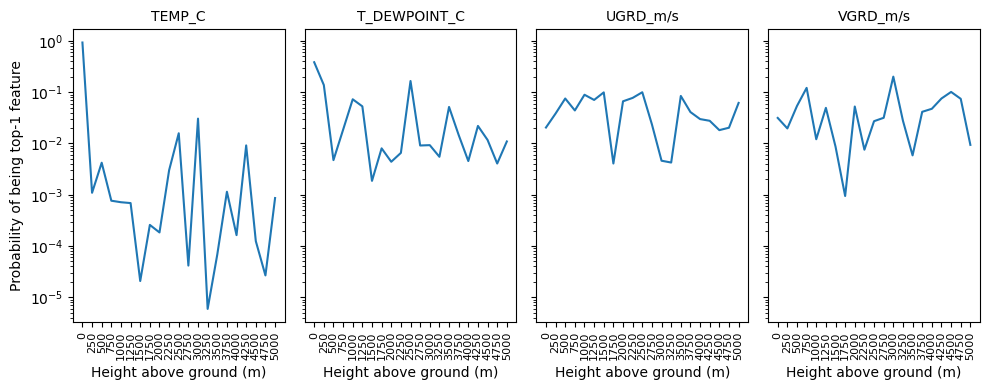

In [25]:
fig, axs = plt.subplots(1, 4, figsize=(10, 4), sharey="row")

titles = ["TEMP_C", "T_DEWPOINT_C", "UGRD_m/s", "VGRD_m/s"]

for k, var in enumerate([conf["TEMP_C"], conf["T_DEWPOINT_C"], conf["UGRD_m/s"], conf["VGRD_m/s"]]):
    ydata = np.array([results[k] for k in var])
    axs[k].plot(var, ydata / sum(ydata))
    _var = [x.split("_")[-2] for x in var]
    _ = axs[k].set_xticks(var, _var, rotation=90, fontsize = 8)
    axs[k].set_yscale("log")
    axs[k].set_title(titles[k], fontsize = 10)

    axs[k].set_xlabel("Height above ground (m)")
axs[0].set_ylabel("Probability of being top-1 feature")
    
plt.tight_layout()

# Conus plots

## 